In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

In [3]:
file_path = "final_dataset.csv"

In [4]:
chunk_size = 200000  # Adjust based on memory availability
filtered_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunk_size, on_bad_lines='skip', encoding='utf-8', low_memory=False):
    filtered_chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
filtered_df = pd.concat(filtered_chunks, ignore_index=True)
del filtered_chunks
print(filtered_df.columns)


Index(['energy_100g', 'saturated_fat_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'fruits_veg_nuts_100g',
       'nutriscore_grade'],
      dtype='object')


In [5]:

# Define features and target
num_features = [
    'energy_100g', 'saturated_fat_100g', 'sugars_100g',
    'fiber_100g', 'proteins_100g', 'salt_100g',
    'fruits_veg_nuts_100g',
]
target = 'nutriscore_grade'

# Split data
X = filtered_df[num_features]
y = filtered_df[target]


In [6]:
# Encode target labels
encoder = OrdinalEncoder()
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1)).ravel()
y_encoded


array([3., 2., 4., ..., 2., 3., 1.])

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Original Training Size: (63889, 7)
Resampled Training Size: (95360, 7)
Test Set Size: (15973, 7)

=== Individual Model Cross-Validation ===

RANDOMFOREST Cross-Validation:
Balanced Accuracy: 0.8729
              precision    recall  f1-score   support

           A     0.9200    0.8989    0.9093     19072
           B     0.8378    0.8594    0.8485     19072
           C     0.8067    0.7849    0.7956     19072
           D     0.8927    0.9078    0.9002     19072
           E     0.9067    0.9134    0.9100     19072

    accuracy                         0.8729     95360
   macro avg     0.8728    0.8729    0.8727     95360
weighted avg     0.8728    0.8729    0.8727     95360


XGBOOST Cross-Validation:
Balanced Accuracy: 0.8505
              precision    recall  f1-score   support

           A     0.8782    0.8850    0.8816     19072
           B     0.8210    0.8349    0.8279     19072
           C     0.7803    0.7396    0.7594     19072
           D     0.8685    0.8808    0.8746

c:\Users\apran\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\apran\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\apran\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\apran\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kw


=== Final Evaluation ===
Balanced Accuracy: 0.8372129847445999

Classification Report:
              precision    recall  f1-score   support

           A     0.6022    0.7866    0.6822       614
           B     0.8387    0.8560    0.8473      3445
           C     0.8379    0.7794    0.8076      4624
           D     0.8225    0.8454    0.8338      2522
           E     0.9198    0.9186    0.9192      4768

    accuracy                         0.8482     15973
   macro avg     0.8042    0.8372    0.8180     15973
weighted avg     0.8511    0.8482    0.8488     15973



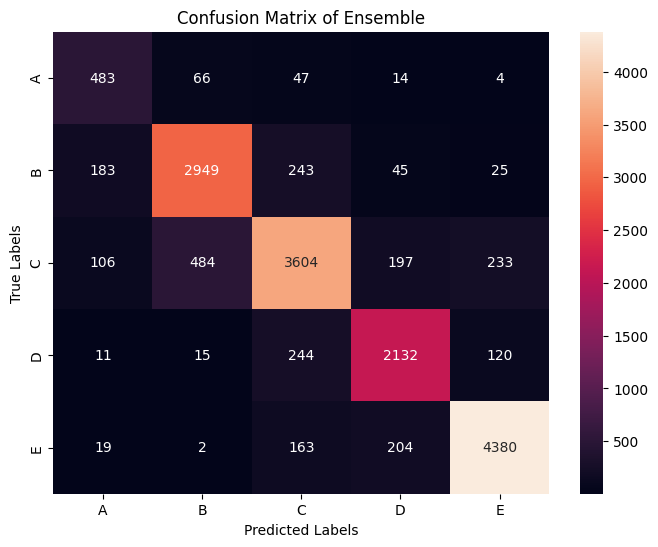

In [ ]:

# Apply SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

# Calibrate models
calibrated_models = [
    ('rf', CalibratedClassifierCV(models['RandomForest'], method='isotonic', cv=5)),
    ('xgb', CalibratedClassifierCV(models['XGBoost'], method='sigmoid', cv=5)),
    ('lgbm', CalibratedClassifierCV(models['LightGBM'], method='isotonic', cv=5)),
]

# Create optimized voting classifier
optimized_voting = VotingClassifier(
    estimators=calibrated_models,
    voting='soft',
    n_jobs=-1
)

# Cross-validation for individual models
print("\n=== Individual Model Cross-Validation ===")
for name, model in calibrated_models:
    print(f"\n{name.upper()} Cross-Validation:")
    y_pred = cross_val_predict(model, X_train_resampled, y_train_resampled, n_jobs=-1, method='predict_proba').argmax(axis=1)
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_train_resampled, y_pred):.4f}")
    print(classification_report(y_train_resampled, y_pred, target_names=['A', 'B', 'C', 'D', 'E'], digits=4))

# Train final ensemble
print("\n=== Final Ensemble Training ===")
optimized_voting.fit(X_train_resampled, y_train_resampled)

# Generate predictions
y_pred = optimized_voting.predict(X_test_scaled)

# Enhanced evaluation metrics
print("\n=== Final Evaluation ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['A', 'B', 'C', 'D', 'E'], digits=4))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", xticklabels=['A', 'B', 'C', 'D', 'E'], yticklabels=['A', 'B', 'C', 'D', 'E'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix of Ensemble")
plt.show()